In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import datetime

In [2]:
# Load the data from gas.csv
df = pd.read_csv('Household Heating Gas.csv')

In [3]:
df

,Location,Month,Prices
0,"St. John's, Newfoundland and Labrador",Jan-90,34.4
1,"St. John's, Newfoundland and Labrador",Feb-90,36.6
2,"St. John's, Newfoundland and Labrador",Mar-90,36.6
3,"St. John's, Newfoundland and Labrador",Apr-90,36.7
4,"St. John's, Newfoundland and Labrador",May-90,36.7
...,...,...,...
6586,"Yellowknife, Northwest Territories",Nov-23,199.0
6587,"Yellowknife, Northwest Territories",Dec-23,197.9
6588,"Yellowknife, Northwest Territories",Jan-24,194.9
6589,"Yellowknife, Northwest Territories",Feb-24,175.0


In [4]:
# Convert 'Month' column to datetime format
df['Month'] = pd.to_datetime(df['Month'], format='%b-%y')


In [5]:
# Extract year and month as separate numerical features
df['Year'] = df['Month'].dt.year
df['Month_Num'] = df['Month'].dt.month

In [6]:
# Clean the data by removing rows with non-numeric values in 'prices' column
df = df[pd.to_numeric(df['Prices'], errors='coerce').notnull()]


In [7]:
# Convert 'prices' column to float
df['Prices'] = df['Prices'].astype(float)


C:\Users\User\AppData\Local\Temp\ipykernel_14812\497285554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prices'] = df['Prices'].astype(float)


In [8]:
# Group the data by 'Location' for predictions
groups = df.groupby('Location')
df

,Location,Month,Prices,Year,Month_Num
0,"St. John's, Newfoundland and Labrador",1990-01-01,34.4,1990.0,1.0
1,"St. John's, Newfoundland and Labrador",1990-02-01,36.6,1990.0,2.0
2,"St. John's, Newfoundland and Labrador",1990-03-01,36.6,1990.0,3.0
3,"St. John's, Newfoundland and Labrador",1990-04-01,36.7,1990.0,4.0
4,"St. John's, Newfoundland and Labrador",1990-05-01,36.7,1990.0,5.0
...,...,...,...,...,...
6586,"Yellowknife, Northwest Territories",2023-11-01,199.0,2023.0,11.0
6587,"Yellowknife, Northwest Territories",2023-12-01,197.9,2023.0,12.0
6588,"Yellowknife, Northwest Territories",2024-01-01,194.9,2024.0,1.0
6589,"Yellowknife, Northwest Territories",2024-02-01,175.0,2024.0,2.0


In [9]:
# Initialize an empty DataFrame to store the predictions
predicted_df = pd.DataFrame()

In [10]:
# Iterate through each group and make predictions
for name, group in groups:
    # Splitting the data into features (X) and target variable (y)
    X = group[['Year', 'Month_Num']]
    y = group['Prices']

    # Training a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Create a DataFrame for future dates for this location
    future_dates = pd.date_range(start=group['Month'].max(), periods=60, freq='M') + datetime.timedelta(days=30)
    future_df = pd.DataFrame({'Month': future_dates})
    future_df['Year'] = future_df['Month'].dt.year
    future_df['Month_Num'] = future_df['Month'].dt.month

    # Make predictions for this location
    future_predictions = model.predict(future_df[['Year', 'Month_Num']])

    # Add predictions to the predicted DataFrame
    future_df['Predicted Prices'] = future_predictions
    future_df['Location'] = name

    # Append the predictions for this location to the overall predicted DataFrame
    predicted_df = pd.concat([predicted_df, future_df])


In [11]:
# Reset the index of the predicted DataFrame
predicted_df.reset_index(drop=True, inplace=True)
predicted_df

,Month,Year,Month_Num,Predicted Prices,Location
0,2024-04-30,2024,4,124.817019,"Charlottetown and Summerside, Prince Edward Is..."
1,2024-05-30,2024,5,125.054032,"Charlottetown and Summerside, Prince Edward Is..."
2,2024-06-30,2024,6,125.291045,"Charlottetown and Summerside, Prince Edward Is..."
3,2024-07-30,2024,7,125.528058,"Charlottetown and Summerside, Prince Edward Is..."
4,2024-08-30,2024,8,125.765071,"Charlottetown and Summerside, Prince Edward Is..."
...,...,...,...,...,...
955,2028-11-30,2028,11,165.130024,"Yellowknife, Northwest Territories"
956,2028-12-30,2028,12,165.481304,"Yellowknife, Northwest Territories"
957,2029-01-30,2029,1,165.366318,"Yellowknife, Northwest Territories"
958,2029-03-02,2029,3,166.068877,"Yellowknife, Northwest Territories"


In [12]:
import hvplot.pandas
# Plotting using hvplot
plot = predicted_df.hvplot.line(x='Month', y='Predicted Prices', by='Location', xlabel='Month', ylabel='Price (Cents per Liter)', title='Household Heating Gas Prediction', hover_cols=['Location'])

# Show the plot
plot

:NdOverlay   [Location]
   :Curve   [Month]   (Predicted Prices,Location)

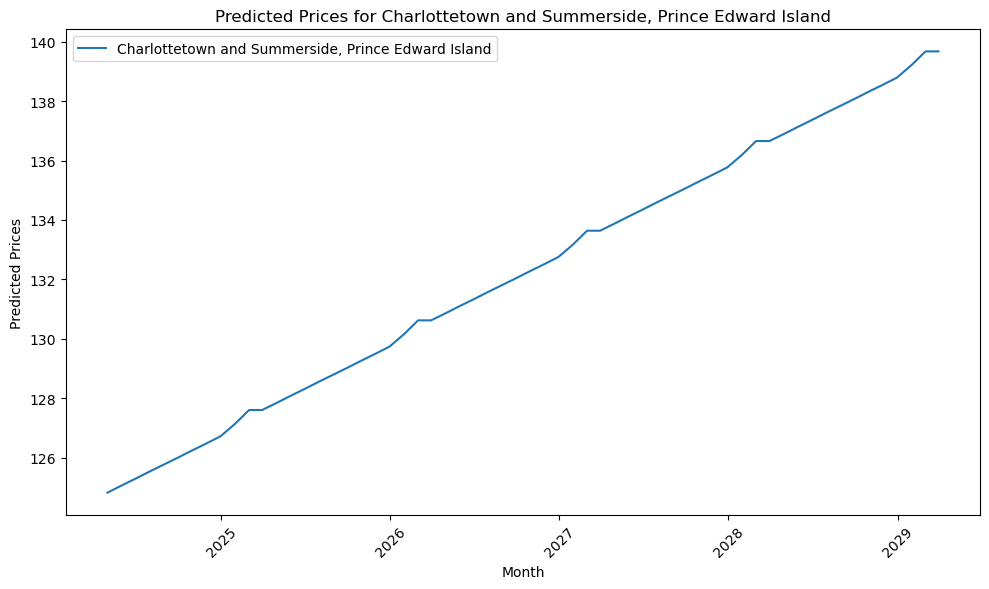

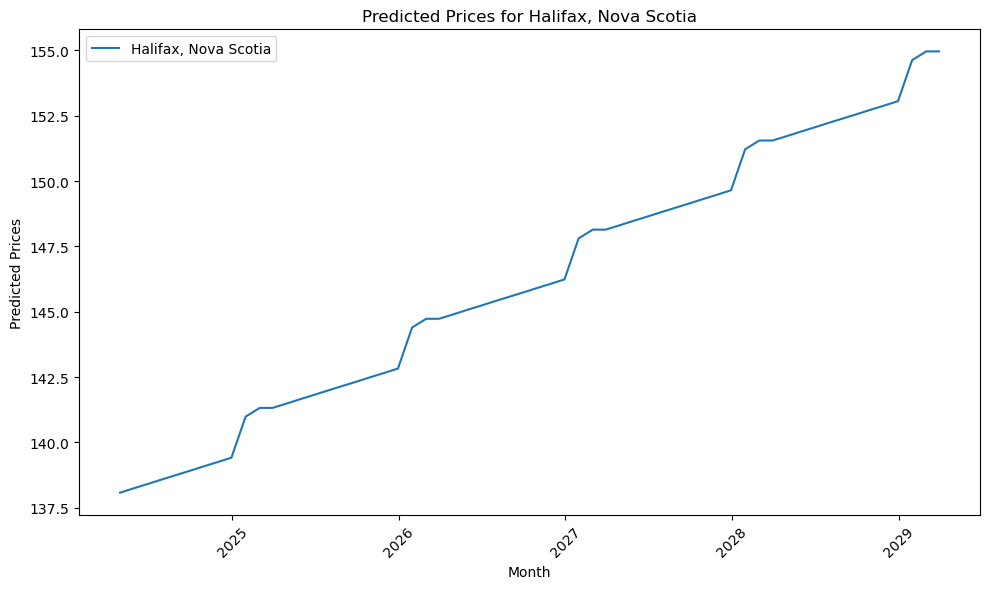

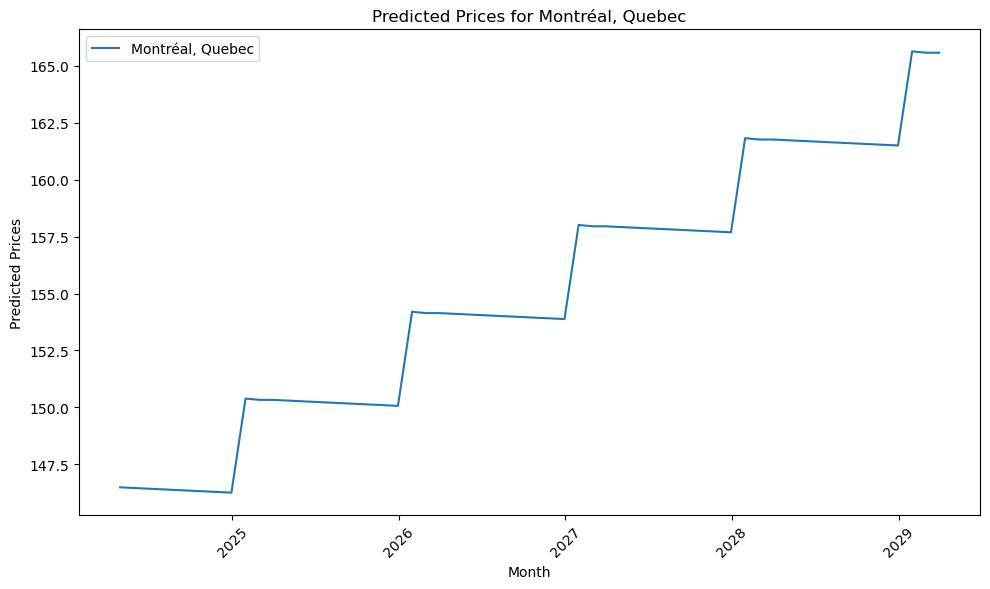

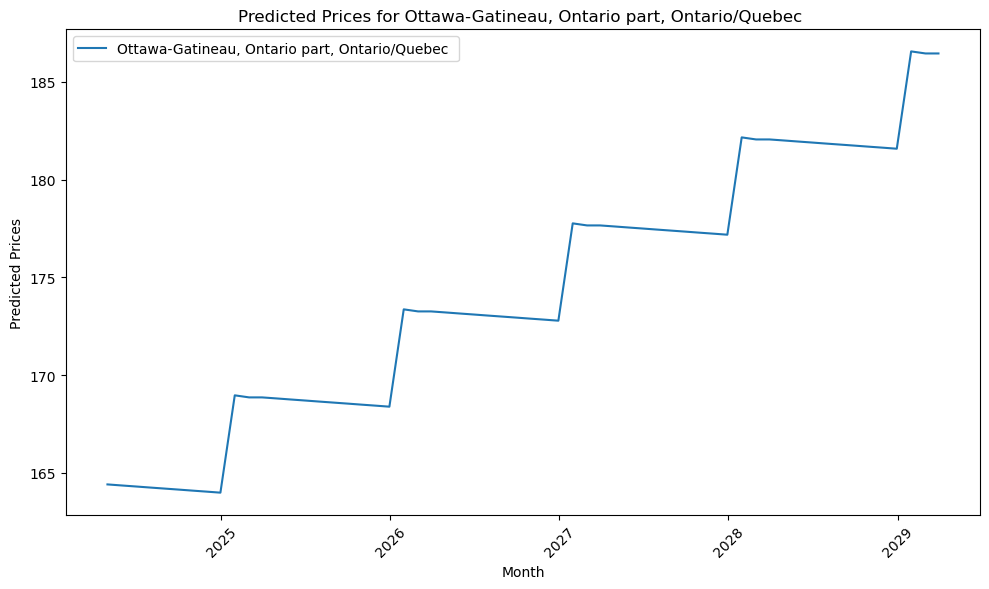

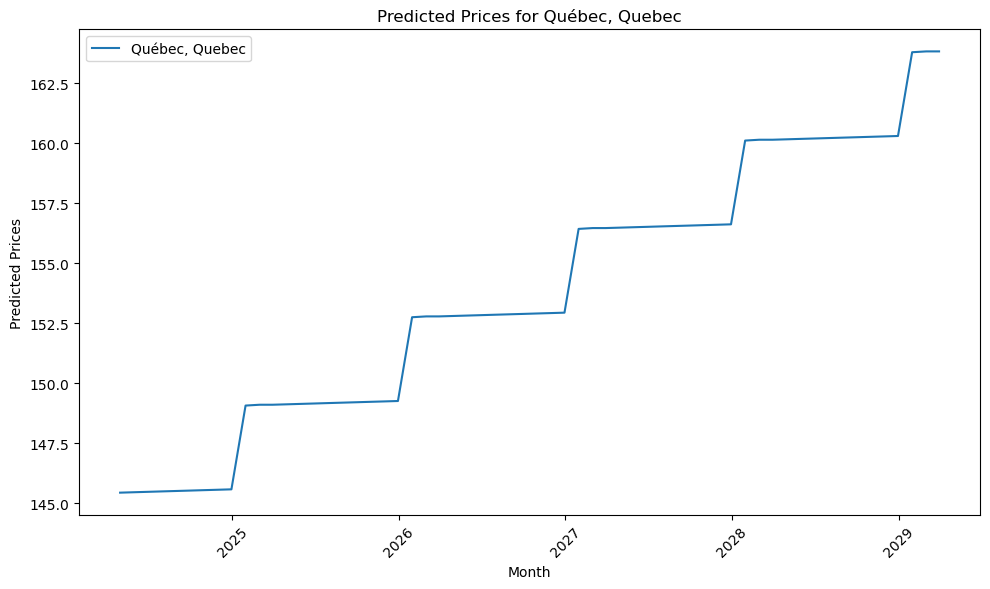

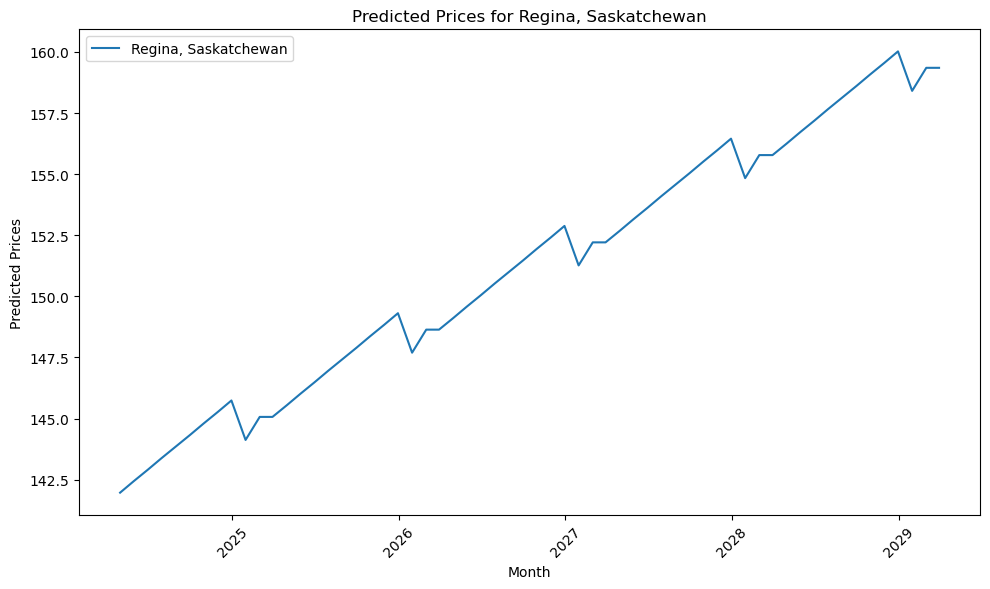

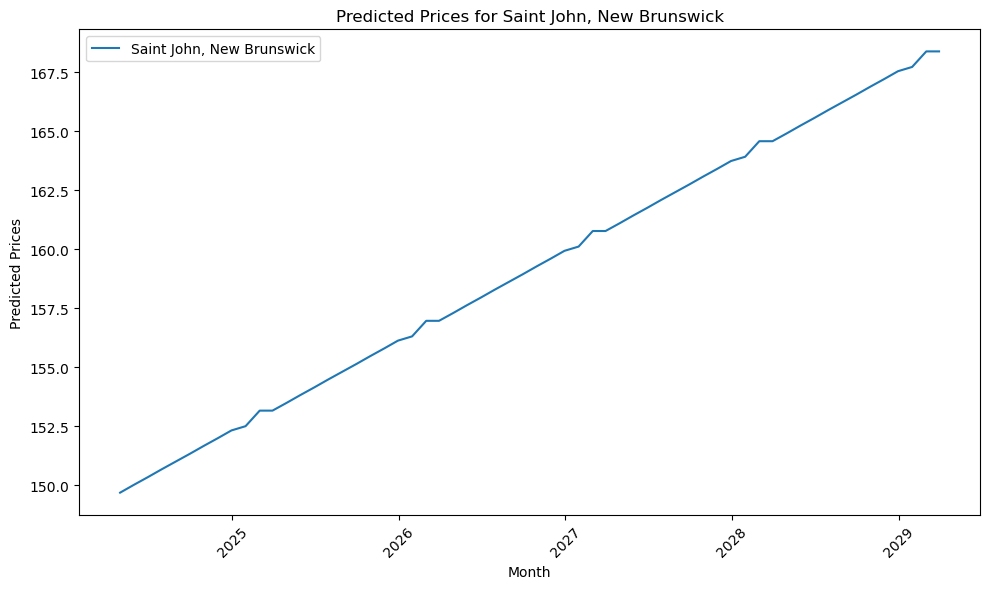

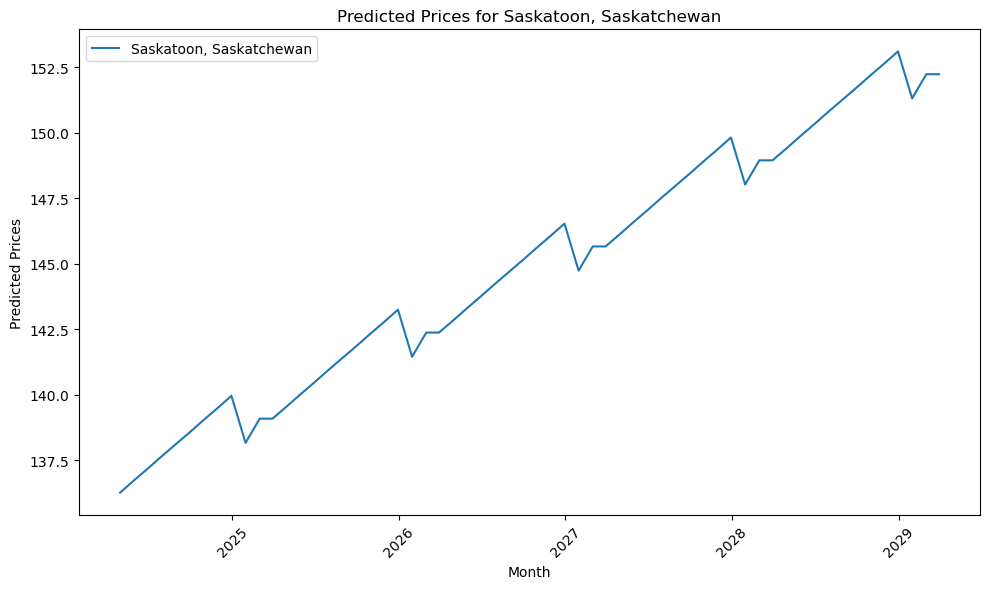

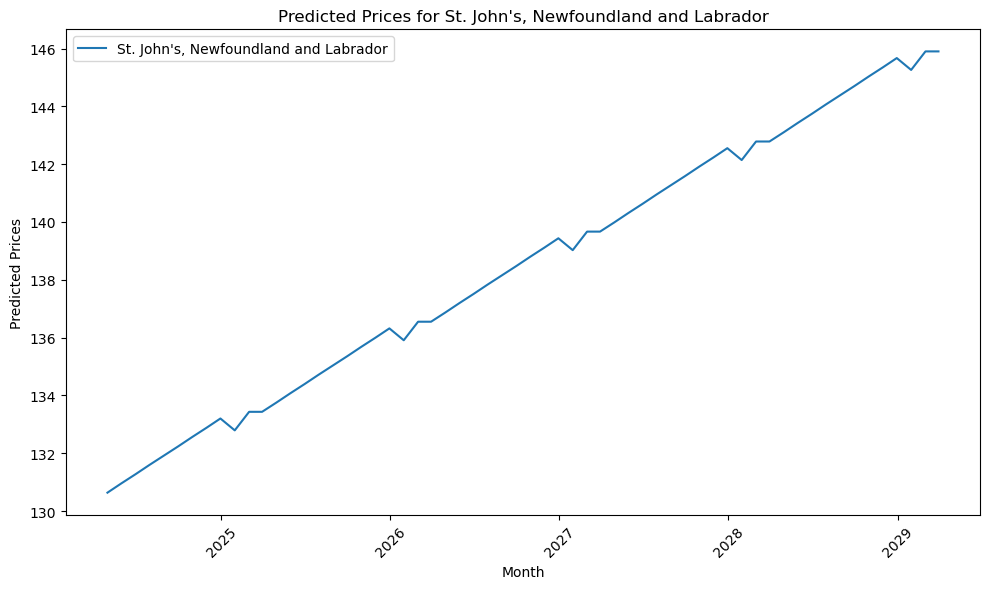

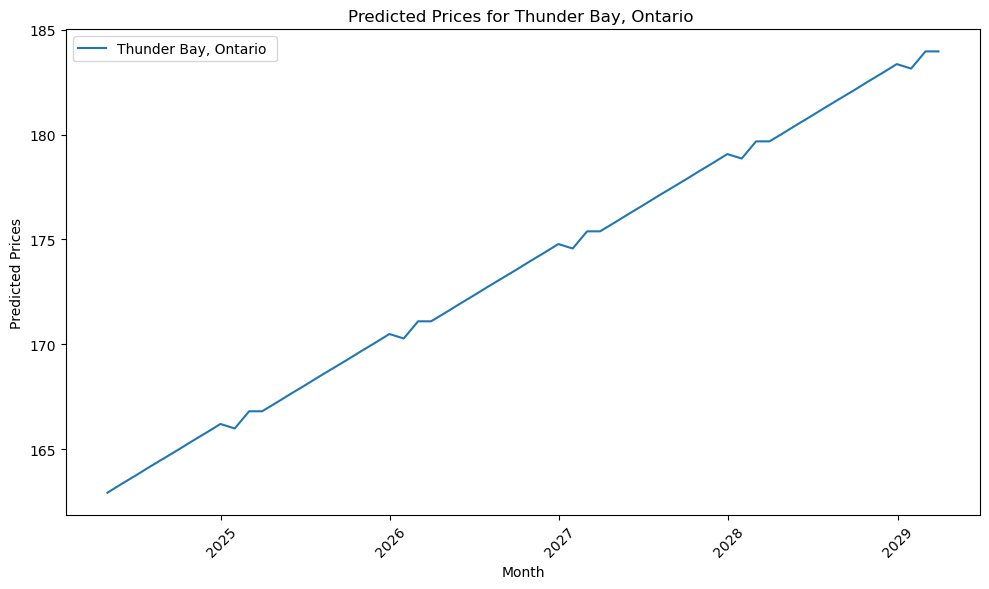

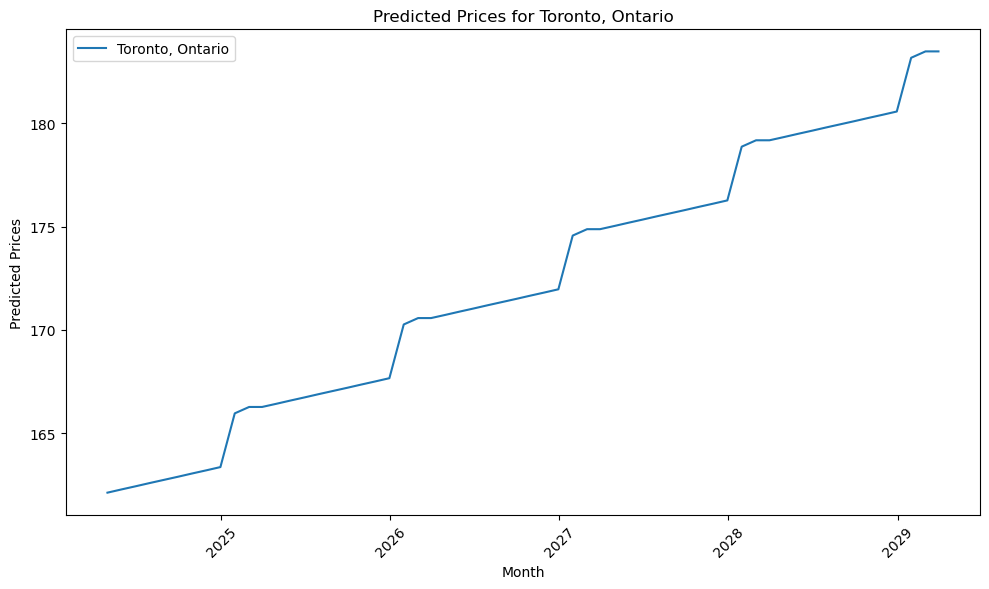

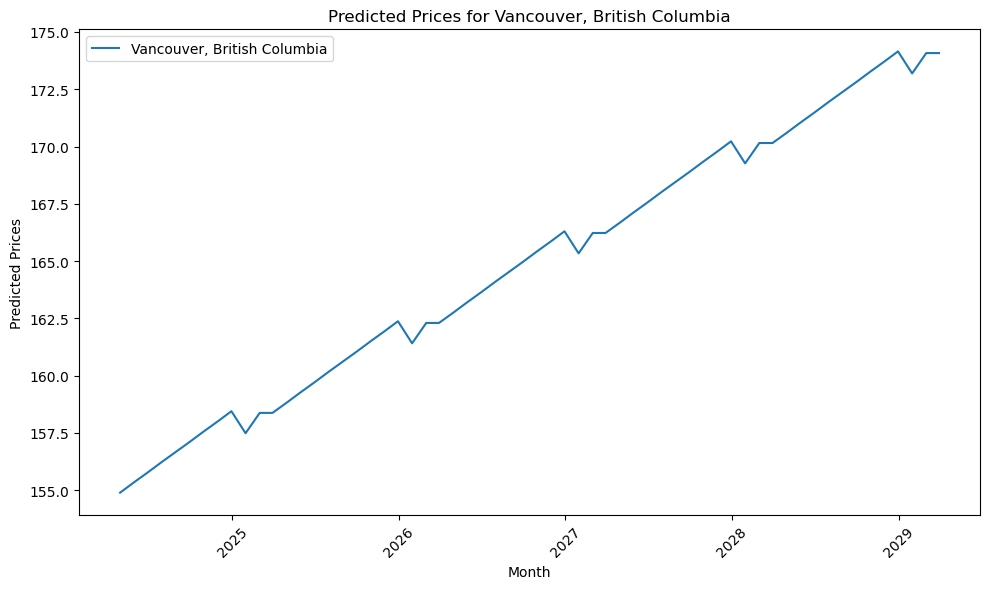

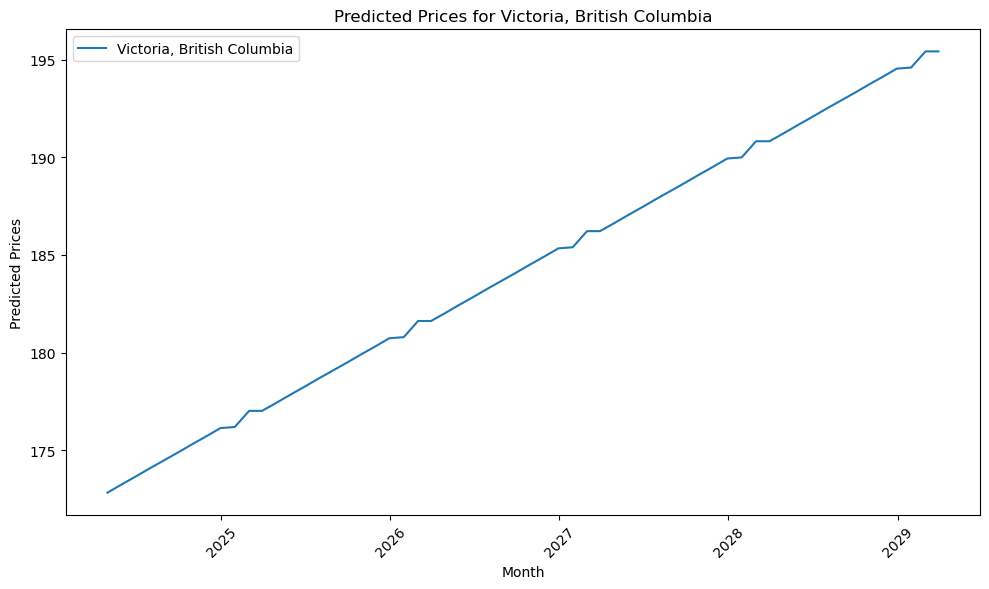

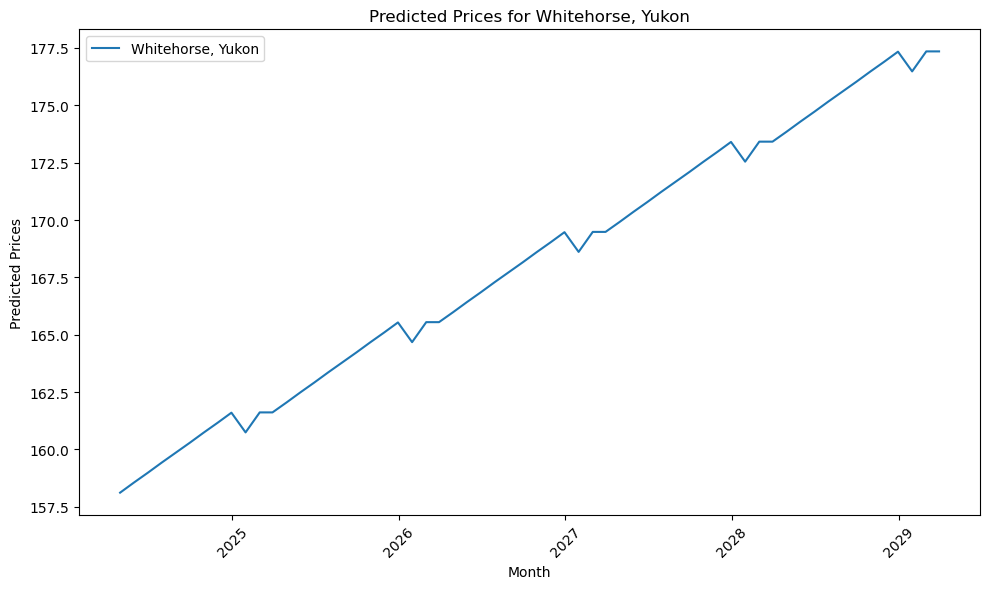

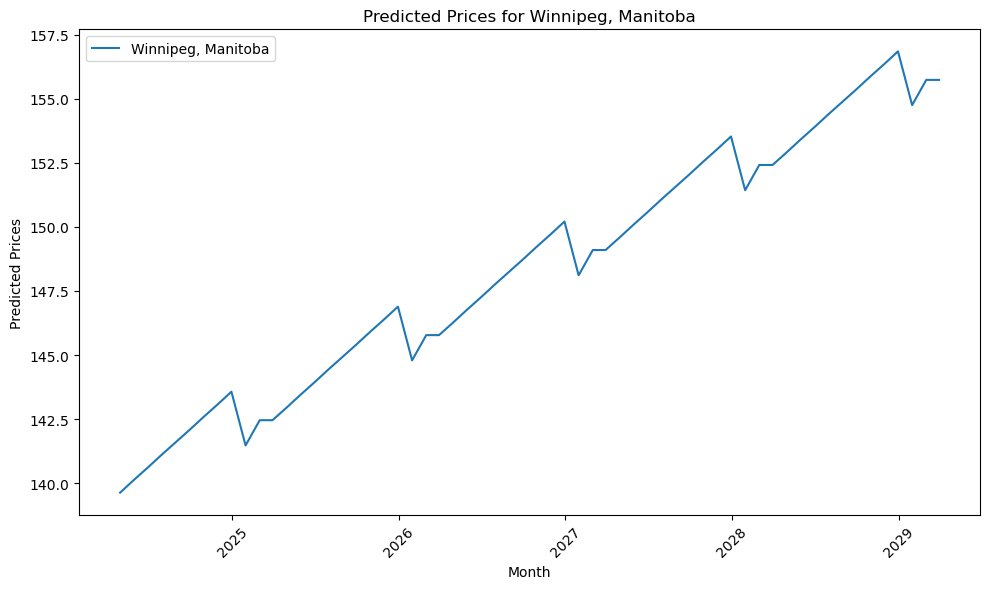

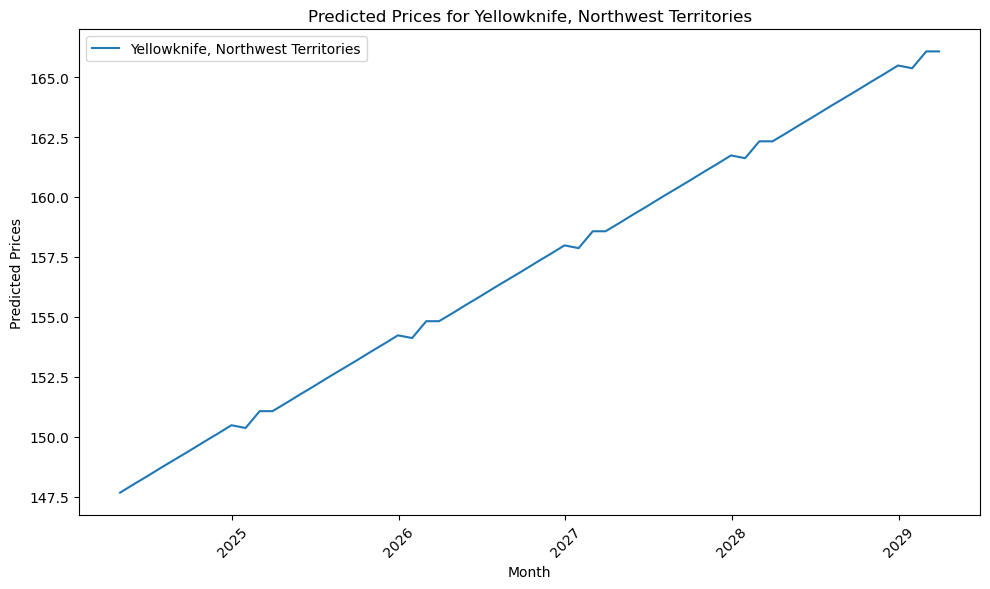

In [13]:
import matplotlib.pyplot as plt

# Iterate through each location and plot the predicted prices
for name, group in predicted_df.groupby('Location'):
    plt.figure(figsize=(10, 6))
    plt.plot(group['Month'], group['Predicted Prices'], label=name)
    plt.xlabel('Month')
    plt.ylabel('Predicted Prices')
    plt.title(f'Predicted Prices for {name}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
